

1.   Murgia Riccardo
2.   0001083930
3.   riccardo.murgia2@studio.unibo.it 



# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [64]:
!pip install datasets
!pip3 install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.1.1
    Uninstalling dill-0.3.1.1:
      Successfully uninstalled dill-0.3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.48.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dill-0.3.1.1-py3-none-any.whl
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.14 requires dill>=0.3.6, but you have dill 0.3.1.1 which is incompatible.


In [ ]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np 
import pickle
import gdown
import random


In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Dataset wikipedia downloaded and prepared to /root/.cache/huggingface/datasets/wikipedia/20220301.simple/2.0.0/aa542ed919df55cc5d3347f42dd4521d05ca68751f50dbc32bae2a7f1e167559. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]


# Tokenization  
tokenizer.fit_on_texts(corpus)
#print(tokenizer.word_index['<unk>'])

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']
#print(eos)
#print(tokenizer.index_word[sos])

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [ ]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]


Let us look at some examples:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 26, 1316, 2103, 32, 8, 878, 23, 228, 3]
shuffled sentecen:  [2, 228, 32, 1316, 878, 23, 8, 26, 2103, 3]


Let us look at detokenized data:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> 3 spaghetti n <end>
shuffled sentence:  <start> spaghetti n 3 <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [65]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)


## Data agumentation

In [66]:
def agumented_data(c_train, x_train, y_train, n):
      orifinal_x = x_train.copy()
      original_y = y_train.copy()

      for _ in range(n):
        c_train_agumented = [random.sample(s[1:-1],len(s)-2) for s in orifinal_x]
        c_train_agumented = [[sos]+s+[eos] for s in c_train_agumented]
        c_train = c_train + c_train_agumented
        x_train = x_train + orifinal_x
        y_train = y_train + original_y
      return c_train, x_train, y_train

c_train, x_train, y_train = agumented_data(c_train, x_train, y_train, n = 2)


Depending from the model you plan to build, you might require padding the input sequence

In [67]:
max_sequence_len = max([len(x) for x in original_data])

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')


In [68]:
print("x_train size:", len(x_train)) 
assert(len(x_train)==len(c_train)==len(y_train))


x_train size: 288330


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

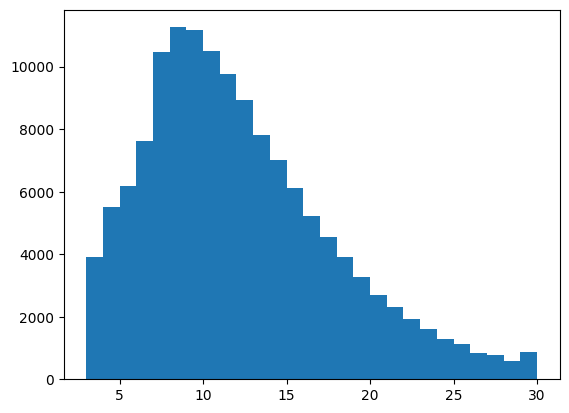

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [ ]:
from difflib import SequenceMatcher

def score(s,p): #original, predicted
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 10K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented. 
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training. 
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Reading some papers and doing some research on the web led me to the creation of several models.
Several architectures widely used in text translation were then tested.

- **Encoder/Decoder model based on LSTM** with attention mechanism and teacher forcing technique as presented in the paper [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)

- **Transformer** made based on the architecture presented within the iconic paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

- **DoubleTransformer** a customized variant composed of two single transformers to which modifications have been made.

The last one was the model used for this assignement.

## Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import os
from tqdm import tqdm


## Hyperparameter


During the model realization, in order to perform hyper-parameter tuning exhaustively, the two transformers were given the freedom to be different by defining a set of hyperparameters for each of them.
In testing, it was then realized that the best results were obtained by setting the two Transformers in a specular manner.  


In [69]:
VOCABOLARY_SIZE = 10000 

# Training Parameter
N_EPOCHS = 35
BATCH_SIZE= 128
VALIDATION_SPLIT = .2

# Beam serch parameter
BEAM_SIZE = 5


# Model Parameter
transformer_1_params = {
    "num_layers" : 4,
    "d_model" : 128,
    "num_heads" : 7,
    "dff" : 254,
    "input_vocab_size" : VOCABOLARY_SIZE,
    "output_vocab_size" : VOCABOLARY_SIZE,
    "dropout_rate" : 0.15,
    "encoder_type" : 'not-positional'
}

transformer_2_params = {
    "num_layers" : 4,
    "d_model" : 128,
    "num_heads" : 7,
    "dff" : 254,
    "input_vocab_size" : VOCABOLARY_SIZE,
    "output_vocab_size" : VOCABOLARY_SIZE,
    "dropout_rate" : 0.15,
    "encoder_type" : 'not-positional'
}



## Model Definition

As mentioned earlier, the proposed model consists of two Transformers.

This idea was born thinking that the model could perform better by training the two transformers on two different shuffles of the same sentence and combining the results through a linear operation. This aspect then made it necessary to perform a data augmentation operation that for each original sentence would generate two different shufles.


The second insight that led to the realization of this architecture is that the model does not need to give importance to the order of the shuffled sentences during encoding. It was therefore chosen to deprive the Encoders within each Transformer of Positional Embedding.





### Positional Embedding

In [70]:
# Define the encodings

def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]    
  depths = np.arange(depth)[np.newaxis, :]/depth   
      
  angle_rates = 1 / (10000**depths)         
  angle_rads = positions * angle_rates     

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], 
                                axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size,
                                               d_model, 
                                               mask_zero=True) 
    
    self.pos_encoding = positional_encoding(length=2048, 
                                            depth=d_model)


  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))                
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


class ClassicalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size,
                                               d_model, 
                                               mask_zero=True) 


  def call(self, x):
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))              

    return x

### Attention Block




In [71]:
# define the Attention 
class Attention(layers.Layer):
  def __init__(self, num_heads, key_dim, dropout_rate):
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.normalization = layers.LayerNormalization(epsilon=1e-6)
        self.dropout = layers.Dropout(dropout_rate)

  def call(self, query, value, key, casual_mask=False, training=True):
        attn_output = self.mha(query=query, value=value, key=key, use_causal_mask=casual_mask, training=training)
        attn_output = self.dropout(attn_output, training=training)
        out = self.normalization(query + attn_output)
        return out
        

### Feed Forward Block

In [72]:
# Define the Feed Forword
class FeedForward(layers.Layer):
  def __init__(self, d_model, dff, dropout_rate):
        super().__init__()
        self.first_dense = layers.Dense(dff, activation='relu')
        self.second_dense = layers.Dense(d_model, activation='relu')
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.dropout = layers.Dropout(dropout_rate)

  def call(self, x, training=True):
        fd = self.first_dense(x)
        sd = self.second_dense(fd)
        output = self.dropout(sd, training=training)
        output = self.norm(x + output)
        return output



### Encoder Layer

In [73]:
# Define the Encoder layer
class EncoderLayer(layers.Layer):
    
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super().__init__()
        self.self_attetion = Attention(num_heads=num_heads, key_dim=d_model, dropout_rate=dropout_rate)
        self.feed_forward = FeedForward(d_model, dff, dropout_rate)
    
    def call(self, x, training=True):
        attn_output = self.self_attetion(query=x, value=x, key=x, training=training)
        ffn_output = self.feed_forward(attn_output)
        return ffn_output
  

### Encoder Block

In [74]:
# Define the Encoder
class Encoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate, embedding_type):
        super().__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        if embedding_type == 'positional':
          self.embedding = PositionalEmbedding(input_vocab_size, d_model)
        else:
           self.embedding =  ClassicalEmbedding(input_vocab_size, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, x, training=True):
        x = self.embedding(x)
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training)

        return x


### Decoder Layer

In [75]:
# Define the Decoder layer
class DecoderLayer(layers.Layer):
    
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super(DecoderLayer, self).__init__()
        self.self_attetion = Attention(num_heads=num_heads, key_dim=d_model, dropout_rate=dropout_rate)
        self.mha = Attention(num_heads=num_heads, key_dim=d_model, dropout_rate=dropout_rate)
        self.feed_forward = FeedForward(d_model, dff, dropout_rate)


    def call(self, x, enc_output, training=True):
        self_attention = self.self_attetion(query=x, value=x, key=x, casual_mask=True, training=training)
        multi_head_attention = self.mha(query=self_attention, value=enc_output, key=enc_output, training=training)
        ffn_output = self.feed_forward(multi_head_attention)

        return ffn_output

### Decoder Block

In [76]:
# Define the Decoder
class Decoder(layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, dropout_rate):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_encoding = PositionalEmbedding(target_vocab_size, d_model)
        self.dropout = layers.Dropout(dropout_rate)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]

    def call(self, x, enc_output, training=True):

        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training=training)

        return x

### Metrics

In [77]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


### Single Transformer

In [78]:
class Transformer(keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, output_vocab_size, dropout_rate, encoder_type):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate, encoder_type)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, output_vocab_size, dropout_rate)
        self.final_layer = layers.Dense(output_vocab_size, activation='softmax')                                                    

    def call(self, input, training=True):
        context, input_sentence = input
        encoder_output = self.encoder(context, training=training)
        decoder_output = self.decoder(input_sentence, encoder_output, training=training)
        final_output = self.final_layer(decoder_output)
        try:
          del final_output._keras_mask
        except AttributeError:
          pass

        return final_output


### Double transformer

This block consists of two Transformers that working in parallel cooperate to efficiently reorder the input sentences.
During the various stages of testing a few different types of optimizer were tried, however, it was found that Adam was the most effective.

In [79]:
class DoubleTransformer(keras.Model):
  def __init__(self, transformer_1_params, transformer_2_params, output_shape):
    super().__init__()
    self.transformer_1 = Transformer(**transformer_1_params)
    self.transformer_2 = Transformer(**transformer_2_params)

  def call(self, input, training=True):
    output_model_1 = self.transformer_1(input, training)
    output_model_2 = self.transformer_2(input, training)
    return output_model_1 + output_model_2                                                              

  def compile(self, lr_1, lr_2):
    learning_rate_1 = CustomSchedule(lr_1)
    learning_rate_2 = CustomSchedule(lr_2)

    optimizer_1 = tf.keras.optimizers.Adam(learning_rate_1, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    optimizer_2 = tf.keras.optimizers.Adam(learning_rate_2, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

    self.transformer_1.compile(loss=masked_loss,
                               optimizer=optimizer_1,
                               metrics=[masked_accuracy])
    
    self.transformer_2.compile(loss=masked_loss,
                               optimizer=optimizer_2,
                               metrics=[masked_accuracy])
    
  
  def save(self, path1, path2):
    self.transformer_1.save_weights(path1)
    self.transformer_2.save_weights(path2)

  def load(self, path1, path2):
    self.transformer_1.load_weights(path1)
    self.transformer_2.load_weights(path2)

  # A customized training method that makes the two transformers train separately  
  def fit(self, x, y, validation_split = .1, epochs=6, batch_size=256, callbacks_1=[], callbacks_2=[]):
    x1, x2 = x
    data_size = x1.shape[0]
    
    print('-'*200)
    print("training transformer 1:")
    print('-' * 200)
    history1 = self.transformer_1.fit([x1[:data_size//2], 
                                      x2[:data_size//2]], 
                                      y[:data_size//2],
                                      epochs=epochs, 
                                      batch_size=batch_size, 
                                      validation_split=validation_split, 
                                      callbacks=callbacks_1
                                      )
    print('-'*200)
    print("training transformer 2:")
    print('-' * 200)
    history2 = self.transformer_2.fit([x1[data_size//2:],
                                       x2[data_size//2:]], 
                                       y[data_size//2:],
                                       epochs=epochs, 
                                       batch_size=batch_size, 
                                       validation_split=validation_split,
                                       callbacks=callbacks_2
                                      )
    
    return history1, history2


## Model Creation

In [80]:
my_d_t = DoubleTransformer(transformer_1_params, transformer_2_params, VOCABOLARY_SIZE)
my_d_t([c_train[:1], x_train[:1]])
my_d_t.compile(254, 254)                                                                 


In [81]:
my_d_t.summary()

Model: "double_transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_2 (Transformer)  multiple                 9917184   
                                                                 
 transformer_3 (Transformer)  multiple                 9917184   
                                                                 
Total params: 19,834,368
Trainable params: 19,834,368
Non-trainable params: 0
_________________________________________________________________


## Fitting the model 

In [ ]:
train = True

path_folder = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Transformer/double_transformer/weights'

path_weigth1 = os.path.join(path_folder, 'best_weights_35_epochs_t1.h5')
path_weigth2 = os.path.join(path_folder, 'best_weights_35_epochs_t2.h5')

if train:
  # Definition of the callbacks that save the best weigths
  
  checkpoint_callback_1 = ModelCheckpoint(filepath=path_weigth1,
                                          monitor='val_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min',
                                          verbose=1
                                        )

  checkpoint_callback_2 = ModelCheckpoint(filepath=path_weigth2,
                                          monitor='val_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min',
                                          verbose=1
                                        )


  # Definition of the callbacks that stop the trainin process if  for 5 epochs the  val_loss dont decreas at last of 0.0009

  early_stopping_1 = EarlyStopping(monitor='val_loss',           # Metric to monitor 
                                patience=5,                      # Number of consecutive epochs without improvement
                                restore_best_weights=True,       # Restore weights of the best epoch 
                                mode='min',                      # minimizing 
                                min_delta=0.001,                 # minimum change between two epochs
                                verbose=1
                                )

  early_stopping_2 = EarlyStopping(monitor='val_loss',           # Metric to monitor 
                                patience=5,                      # Number of consecutive epochs without improvement
                                restore_best_weights=True,       # Restore weights of the best epoch
                                mode='min',                      # minimizing
                                min_delta=0.001,                 # minimum change between two epochs
                                verbose=1
                                )



  history_1, history_2 = my_d_t.fit([c_train, x_train],
                                    y_train, 
                                    epochs=N_EPOCHS, 
                                    batch_size=BATCH_SIZE, 
                                    validation_split = VALIDATION_SPLIT,
                                    callbacks_1=[early_stopping_1, checkpoint_callback_1],
                                    callbacks_2=[early_stopping_2, checkpoint_callback_2]
                                   )
else:
  my_d_t.load('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Transformer/double_transformer/weights/best_weights_35_epochs_t1.h5', 
              '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Transformer/double_transformer/weights/best_weights_35_epochs_t2.h5')



--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
training transformer 1:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/35
902/902 [==============================] - ETA: 0s - loss: 7.1796 - masked_accuracy: 0.1522
Epoch 1: val_loss improved from inf to 5.39163, saving model to /content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Transformer/double_transformer/weights/best_weights_35_epochs_t1.h5
902/902 [==============================] - 137s 111ms/step - loss: 7.1796 - masked_accuracy: 0.1522 - val_loss: 5.3916 - val_masked_accuracy: 0.2911
Epoch 2/35
902/902 [==============================] - ETA: 0s - loss: 4.5140 - masked_accuracy: 0.3749
Epoch 2: val_loss improved from 5

## Plotting the training process

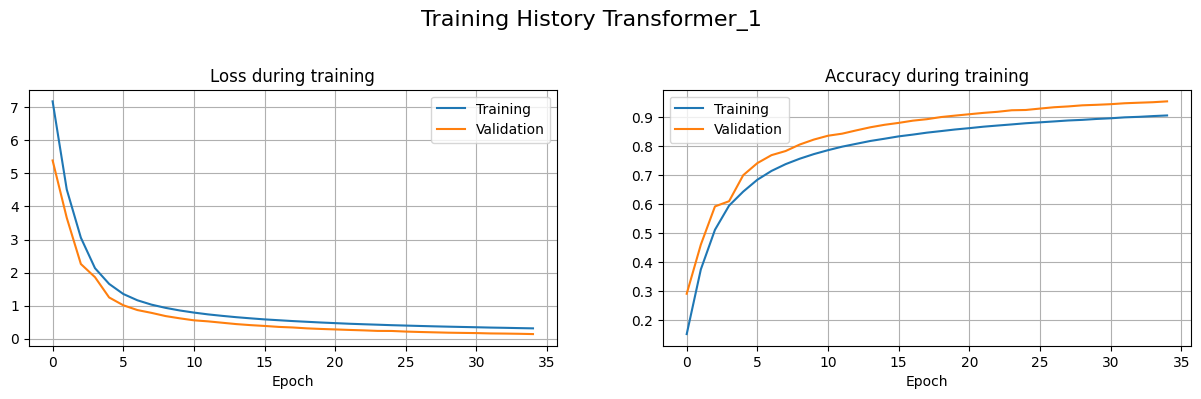

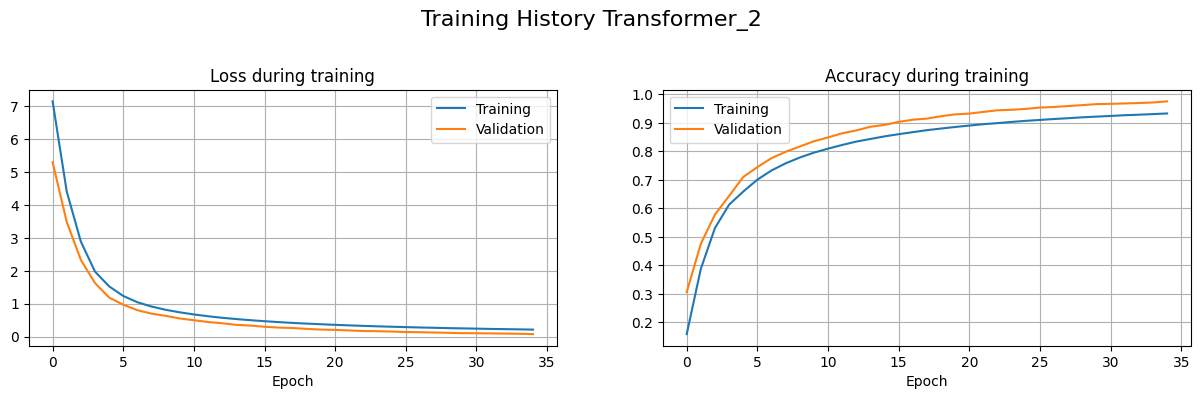

In [ ]:
def display_history(model_fit, model_name):
    print(model_fit)
    mse_training = model_fit.history['loss']
    acc_training = model_fit.history['masked_accuracy']

    mse_val = model_fit.history['val_loss']
    acc_val = model_fit.history['val_masked_accuracy']

    fig, axs = plt.subplots(1, 2, figsize=(15, 4))  

    axs[0].plot(mse_training)
    axs[0].plot(mse_val)
    axs[0].grid()
    axs[0].set_title('Loss during training')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training', 'Validation'])

    axs[1].plot(acc_training)
    axs[1].plot(acc_val)
    axs[1].grid()
    axs[1].set_title('Accuracy during training')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training', 'Validation'])

    fig.text(0.5, 0.95, 'Training History ' + model_name, ha='center', va='top', fontsize=16)
    fig.subplots_adjust(top=0.75)

    plt.show()


display_history(history_1, 'Transformer_1');
display_history(history_2, 'Transformer_2');                                                                    


As can be seen from the graphs above the training process does not characterize any symptoms of overfitting

## Test the Model

The realized model generates sentences one token at a time by basing the generation of a new token on the previous one.
The choice of this token can be made through several strategies 

- **GreedySearch**: simpler implementation and higher performance from the point of view of computational complexity 
- **BeamSearch**: despite the increased computational complexity the implementation could lead to impruvemnt. ([More info](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a2))

The first technique generates each token by extracting the one with the highest probability of being associated with the previous token.
While the Beam Search goes to consider a number n of tokens with maximum probability and from each of them tries to generate a new token proceeding so iteratively until it produces a number n of sentences from which it then extrapolates the most probable one associating to the probability of the sentence the joint probability of each token.



### Gready Search  Definition

In [ ]:
def greedySearch(input_sequence, masking=True):
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, sos)
    stop_condition = False

    for i in range(32):
      output = tf.transpose(output_array.stack())
      output = output.numpy().reshape((1,output.shape[0]))
      predictions = my_d_t([input_sequence, output], training=False)
      predictions = predictions[0, -1:, :]
      predictions = predictions.numpy()
      predicted_id = tf.argmax(predictions, axis=-1)
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == eos:
        break

    output = tf.transpose(output_array.stack())
    return output.numpy()


### My Beam search 

In [ ]:
BEAM_SIZE = 5

def convert_sequence(input_sequence): 
  mask = [0, 1, 2, 3]
  input_sequence = np.array(input_sequence)
  input_sequence = input_sequence[~np.isin(input_sequence, mask)]
  input_sequence = tokenizer.sequences_to_texts([input_sequence])
  return input_sequence


def predict(input_tokens, sequence):
  sequence = sequence.reshape(1,32)

  output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
  output_array = output_array.write(0, input_tokens)
  output = tf.transpose(output_array.stack())
  output = output.numpy().reshape((1, output.shape[0]))

  output_probs = my_d_t([sequence, output], training=False)
  return output_probs[0, -1, :].numpy()

def beam_engine(candidates_sentences,candidates_probabilities, sequence, 
               beam_size, mask):
  
    actual_tokens = []
    actual_probabilities = []

    for i in range(beam_size):
        new_logits = predict(candidates_sentences[i], sequence) 
        new_logits[mask] = float('-inf')
        new_tokens = np.argpartition(new_logits, -beam_size)[-beam_size:].tolist()
        
        new_probabilities = new_logits[new_tokens]

        for element in new_tokens:      
          actual_tokens.append(candidates_sentences[i] + [element])

        actual_probabilities = np.append(actual_probabilities,
                                         new_probabilities * candidates_probabilities[i])

    proposed_sequences = np.argpartition(actual_probabilities, -beam_size)[-beam_size:]

    candidates_sentences = [actual_tokens[i] for i in proposed_sequences]
    candidates_probabilities = [actual_probabilities[i] for i in proposed_sequences]
     
    return candidates_sentences, candidates_probabilities


def beam_search(sequence, vocabulary_dim, beam_size):
    mask = np.full(vocabulary_dim, True, dtype=bool)
    mask[sequence] = False

    sos_token = np.zeros((1, 1))
    sos_token[0, 0] = sos

    sos_logits = predict(sos_token, sequence)
    sos_logits[mask] = float('-inf')
    sos_tokens = np.argpartition(sos_logits, -beam_size)[-beam_size:].tolist()
    candidates_probabilities = sos_logits[sos_tokens].tolist()

    candidates_sentences = []
    for i in range(beam_size):
       candidates_sentences.append([sos,sos_tokens[i]])

    for i in range(len(sequence) - 1):
      candidates_sentences, candidates_probabilities = beam_engine(candidates_sentences,
                                                                  candidates_probabilities,
                                                                  sequence,beam_size,mask)
      if candidates_sentences[0][-1] == eos:
          break
  
    return candidates_sentences[np.argmax(candidates_probabilities)]


### Comparison between GreedySearch and BeamSearch

An initial test case was chosen by going to consider a small set of number of items so that the quality of sentence reconstruction through the two techniques could be verified visually.




In [ ]:
nbr_sents_2_test = 50

scores_vector_beam_seach = []
scores_vector_arg_max = []

for i in range(nbr_sents_2_test):
  print('-'*200)
  print(i, "/", nbr_sents_2_test)

  print('Index phrase:', i)
  s = convert_sequence(y_test[i])[0]
  p = convert_sequence(beam_search(c_test[i], VOCABOLARY_SIZE, BEAM_SIZE))[0]

  print("Correct sequence     :", s)
  print("Predict sequence beam:", p)

  sco_beam = score(p,s)
 
  p = convert_sequence(greedySearch(c_test[i].reshape(1,32), VOCABOLARY_SIZE))[0]
  print("Predict sequence arg :", p)
  sco_argmax = score(p,s)
  
  print("Score with Beam search:", sco_beam)
  print("Score with arg max:    ", sco_argmax) 

  scores_vector_beam_seach.append(sco_beam)
  scores_vector_arg_max.append(sco_argmax)


my_score_beam = np.mean(scores_vector_beam_seach)
my_score_argmax = np.mean(scores_vector_arg_max)

print('=' * 200)
print("Final Score beam: ", my_score_beam)
print("Final Score armax:", my_score_argmax)


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0 / 50
Index phrase: 0
Correct sequence     : in pittsburgh pennsylvania on august 6 1928
Predict sequence beam: on august 6 1928 in pittsburgh pennsylvania
Predict sequence arg : on 6 august 1928 in pittsburgh pennsylvania
Score with Beam search: 0.6046511627906976
Score with arg max:     0.6046511627906976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1 / 50
Index phrase: 1
Correct sequence     : its area is
Predict sequence beam: its area is
Predict sequence arg : its area is
Score with Beam search: 1.0
Score with arg max:     1.0
--------------------------------------------------------------------------------------------------------

### Final Test  

A more general test case was chosen considering a set of 3000 sentences to be reordered to produce the required score.
The test was carried out using both GreedySearch and BeamSearch so as to highlight the performance achieved by the model using both techniques. 

#### Final results GreedySearch

The following is the result obtained by applying the GreedySearch

In [86]:
# This function has been implemented in order to speed up the test
def predictBatch(input_sequences):
        batch_size = input_sequences.shape[0]

        encoder_input = input_sequences
        
        decoded_indexes = [[tokenizer.word_index['<start>']] for _ in range(batch_size)]

        for i in range(1, max_sequence_len):
            decoder_input = tf.convert_to_tensor(decoded_indexes)

            predictions = np.array(my_d_t([encoder_input, decoder_input], training=False))
            predictions = predictions[:, -1, :]
            sampled_token_index = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
          
            for ind in range(batch_size):
              decoded_indexes[ind].append(int(sampled_token_index[ind]))             


        return decoded_indexes

In [87]:
total_score = 0
num_examples = 3000
start_id = 0
batch = 500


possible_choice = [i for i in range(len(c_test))]
predicted_sequences_tot = []

for i in tqdm(range(start_id, (start_id+num_examples)//batch)):
  begin = i*batch
  end = (i+1)*batch

  random_index = randomizer.choice(possible_choice)
  possible_choice.remove(random_index)

  predicted_sequences = predictBatch(c_test[begin:end])
  predicted_sequences_tot += predicted_sequences


for i in (range(start_id, start_id+num_examples)):
    original_sentence = tokenizer.sequences_to_texts([x_test[i][1:-1]])[0].replace(' <pad>', '').replace('<start> ', '').replace(' <end>', '')
    
    prediction = predicted_sequences_tot[i]
    if(eos in prediction):
      end_token_index = prediction.index(eos)
      prediction = prediction[:end_token_index+1]
    
    predicted_sentence = tokenizer.sequences_to_texts([prediction])
    predicted_sentence = predicted_sentence[0].replace('<start> ', '').replace(' <end>', '')
    total_score += score(predicted_sentence, original_sentence)

arg_max_score = (total_score / num_examples) 


print('\n======================================================================')
print("|               FINAL SCORE:                     ", arg_max_score   ,"|")
print('======================================================================')

100%|██████████| 6/6 [01:50<00:00, 18.49s/it]



|               FINAL SCORE:                      0.5385042324427607 |


#### Final result BeamSearch

The following cell is designed to allow partial results to be saved ensuring that what is calculated is not lost due to runtime disconnects. the achieved score is then saved whenever 500 elements are processed up to a total of 3000 also going to exclude the possibility that some input phrase may be tested multiple times, and giving the possibility to restart from a checkpoint. 

The following is the result obtained by applying the BeamSearch

In [85]:
final_test_case_nbr = 500

possible_choice = [i for i in range(len(c_test))]
final_mean_score = []


for j in range(6):
  mean_score = []
  filename = f'/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Transformer/double_transformer/results/final_score_{j}.pkl'
  if os.path.exists(filename):
      with open(filename, "rb") as f:
          loaded_object = pickle.read(f)
      final_mean_score.append(loaded_object['partial tests'+ str(j)])
      possible_choice = loaded_object['possiblechoice_step_'+ str(j)]
  else:
      for i in tqdm(range(final_test_case_nbr)):
        random_index = randomizer.choice(possible_choice)
        possible_choice.remove(random_index)

        s = convert_sequence(y_test[random_index])[0]
        p = convert_sequence(beam_search(c_test[random_index], VOCABOLARY_SIZE, BEAM_SIZE))[0]
        
        sco_beam = score(p, s)

        mean_score.append(sco_beam)

      with open(filename, 'wb') as f:
        pickle.dump({
            'partial tests'+ str(j): np.sum(mean_score),
            'possiblechoice_step_'+ str(j): possible_choice
        }, f)
      final_mean_score.append(np.sum(mean_score))


my_score_beam = np.sum(final_mean_score) / 3000


print('\n======================================================================')
print("|               FINAL SCORE:                     ", my_score_beam , "|")
print('======================================================================')


100%|██████████| 500/500 [1:58:36<00:00, 14.23s/it]


|               FINAL SCORE:                      0.5409169784702489 |


## Conclusion

In the initial test case involving a set of 50 sentences, a notable disparity of two scores was observed between the two techniques (BeamSearch: 0.5793192358560276 vs GreedySearch: 0.5502334739391664). This highlights the superior performance of BeamSearch compared to GreedySearch.

The final test, as requested, was conducted on a set of 3000 sentences. It revealed that the BeamSearch technique performs better, albeit to a lesser extent. Consequently, I have chosen to utilize this technique alongside the model.



**MY BEST SCORE**
---

**0.5409169784702489**.

---

